First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/wilson-labs/cola.git

# Computing the eigenspectrum of the Hessian of a Neural Network

In this notebook we will consider computing the eigenvalues of the Hessian of the loss function for a ResNet18.

In [1]:
%pip install -q timm
%pip install -q detectors

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


First let's load a pretrained resnet18 model on CIFAR10 and verify that it is loaded correctly.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import detectors
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trainset = torchvision.datasets.CIFAR10(root=os.path.expanduser('~/datasets'), train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
testset = torchvision.datasets.CIFAR10(root=os.path.expanduser('~/datasets'), train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False)
criterion = torch.nn.CrossEntropyLoss()

# Load pretrained ResNet18 model and verify the results
model = timm.create_model("resnet18_cifar10", pretrained=True).to(device).eval()
with torch.no_grad():
    correct = sum((model(images.to(device)).argmax(1) == labels.to(device)).sum().item() for images, labels in testloader)
accuracy = 100 * correct / len(testset)
print(f"Test accuracy: {accuracy:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Test accuracy: 94.98%


Next we will define a function that computes the loss explicitly as a function of the parameters, so we can compute the Hessian of this function.

In [2]:
import torch.func as tf
from torch.utils._pytree import tree_flatten, tree_unflatten

# make stateless model
def flatten_params(params):
    shapes = [p.shape for p in params]
    flat_params = torch.cat([p.flatten() for p in params])
    return flat_params, shapes


def unflatten_params(flat_params, shapes):
    params = []
    i = 0
    for shape in shapes:
        size = torch.prod(torch.tensor(shape)).item()
        params.append(flat_params[i:i + size].view(shape))
        i += size
    return params

flat_p, shape = flatten_params(list(model.parameters()))
flat_p = flat_p.detach().requires_grad_(True)

def stateless_model(flatparams, x):
    params = unflatten_params(flatparams, shape)
    names = list(n for n, _ in model.named_parameters())
    nps = {n: p for n, p in zip(names, params)}
    return tf.functional_call(model, nps, x)

def flat_loss(X,y,params):
    return criterion(stateless_model(params, X).reshape(X.shape[0],-1), y)

Now we will define the Hessian of this loss function. Due to memory constraints we cannot compute the loss for the entire dataset simultaneously, so instead we need to loop over the elements in the dataloader. For this we will create a new linear operator `BatchedHessian`

In [3]:
import cola
from functools import partial

class BatchedHessian(cola.ops.LinearOperator):
    def __init__(self, loss, params, dataloader):
        self.loss = loss
        self.params = params
        self.dataloader = dataloader
        super().__init__(dtype=params.dtype, shape=(params.numel(), params.numel()),
                        annotations={cola.SelfAdjoint}) # mark it as self-adjoint

    def _matmat(self, V):
        HV = torch.zeros_like(V)
        with torch.no_grad():
            n = 0
            for X,y in self.dataloader:
                with torch.enable_grad():
                    H = cola.ops.Hessian(partial(self.loss, X.to(self.device), y.to(self.device)), self.params)
                    out = H@V
                    n +=1
                HV += out
        return HV/n

In [4]:
H = BatchedHessian(flat_loss, flat_p, testloader)

As we can see, the matrix is of considerable size because of the 10M+ parameters of the model.

In [5]:
print(f"size of Hessian: {H.shape}")

size of Hessian: (11173962, 11173962)


Now we will use Lanczos to compute the largest 10 eigenvalues. Setting the maximum iterations to $30$ in order for the computation to only take ~15 minutes, but with more time we can get more eigenvalues.

In [6]:
eigs, eigvecs = cola.eig(H, 10, which='LM',alg=cola.Lanczos(max_iters=30, tol=1e-3, pbar=True))

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

We can see the spectrum below.

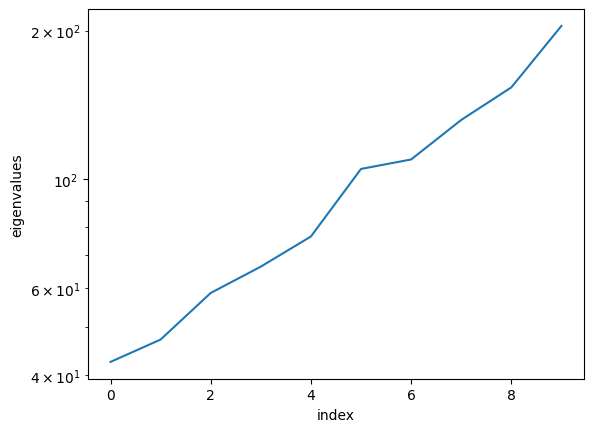

In [7]:
import matplotlib.pyplot as plt
plt.plot(eigs.cpu().data.numpy())
plt.yscale('log')
plt.ylabel('eigenvalues')
plt.xlabel('index')
plt.show()